<h1>Project 3: Face Morphing!</h1>

<h3>Part 1. Defining Correspondences</h3>


In [4]:
import numpy as np
from scipy.spatial import Delaunay
import json
import matplotlib.pyplot as plt
import cv2
import skimage
from scipy.interpolate import griddata
from PIL import Image
import imageio
import os

In [20]:
#open it to read the correspondences points
with open('cillian_benedict.json', 'r') as correspondences:
    points = json.load(correspondences)

cillianpts = np.array(points['im1Points'])
benedictpts = np.array(points['im2Points'])

print(cillianpts.shape, benedictpts.shape)

#calculate midpoints
cb_midpoints = []
for p_im1, p_im2 in zip(cillianpts, benedictpts):
    mean_x = (p_im1[0] + p_im2[0]) / 2
    mean_y = (p_im1[1] + p_im2[1]) / 2
    cb_midpoints.append([mean_x, mean_y])

cb_midpoints = np.array(cb_midpoints)
cb_mid_triangulation = Delaunay(cb_midpoints)

(51, 2) (51, 2)


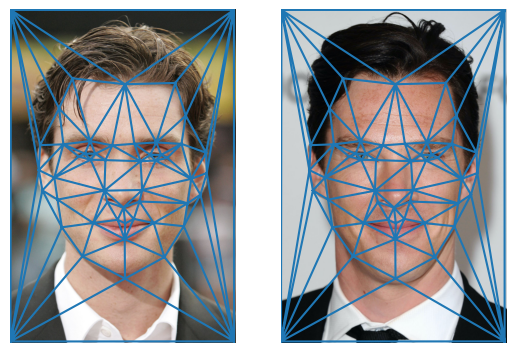

In [21]:
plt.subplot(121)
impath = 'cillianresized.jpg'
img = plt.imread(impath)
plt.imshow(img)
plt.triplot(cb_midpoints[:, 0], cb_midpoints[:, 1], cb_mid_triangulation.simplices)
plt.axis('off')

plt.subplot(122)
impath = 'benedictresized.jpg'
img = plt.imread(impath)
plt.imshow(img)
plt.triplot(cb_midpoints[:, 0], cb_midpoints[:, 1], cb_mid_triangulation.simplices)
plt.axis('off')
plt.savefig('trianglemesh.jpg')
plt.show()


<h3>Part 2: Computing the "Mid-way Face"</h3>

In [22]:
def computeAffine(tri_orig, tri2_goal):
    # Calculate the affine transformation matrix A
    A = np.vstack((tri_orig.T, [1, 1, 1])).T
    B = np.vstack((tri2_goal.T, [1, 1, 1])).T

    T = np.linalg.solve(A,B).T
    return T

In [23]:
def warp(impath, midpoints, cillianpts, curr_pts = []):
    #use Delaunay trigulation calculated from above for both faces
    # midpoints = np.array(midpoints)
    mid_triangulation = Delaunay(midpoints)

    triangles_mid = midpoints[mid_triangulation.simplices]
    if len(curr_pts) == 0:
        #convert from Delaunay object to triangles (each with the three specific points in x an y loc)
        triangles_cillian = cillianpts[mid_triangulation.simplices]
    else: triangles_cillian = curr_pts[mid_triangulation.simplices]

    img = skimage.io.imread(impath)
    img = skimage.img_as_float(img)
    midway_face = np.zeros_like(img)

    # Loop through each triangle and compute the affine transformation matrix
    for tri1_pts, tri2_pts in zip(triangles_cillian, triangles_mid): #tri1 in x,y
        #inverse transformation
        A = computeAffine(tri1_pts, tri2_pts)
        #generate mask
        rr, cc = skimage.draw.polygon(tri1_pts[:,1], tri1_pts[:,0])
        #1s and 0s where 1s are the actual triangle (filled)
        mask = np.zeros(img.shape) #either cillian or benny
        mask[rr, cc] = 1
        
        #we get the points in the triangle that we actually need to warp
        rr2, cc2 = skimage.draw.polygon(tri2_pts[:,1], tri2_pts[:,0])
        warp_pts = np.around(np.vstack((cc2, rr2, np.ones(len(cc2))))).astype(int).T
        coords = np.dot(np.linalg.inv(A), warp_pts.T)

        #interpolate for R, G, and B
        currtri_pts = (rr, cc) #match elements pairwise to get array of all x,y points in triangle
        interp_pts = (coords[1], coords[0])
        
        for ch in range(3): #r, g, b
            vals = img[:,:,ch][(rr,cc)]
            interpolated_vals = griddata(currtri_pts, vals, interp_pts, method='nearest')
            midway_face[rr2, cc2, ch] = interpolated_vals
        #midway_face = np.clip(midway_face, 0, 255)

    # Normalize the midway_face image
    plt.axis('off')
    plt.imshow(midway_face)
    return midway_face

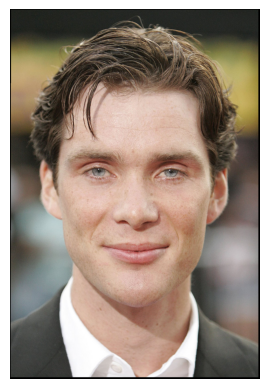

In [24]:
cillianwarped = warp('cillianresized.jpg', cb_midpoints, cillianpts)
plt.savefig('cillianwarped.jpg')

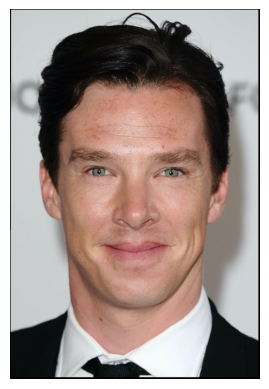

In [25]:
benedictwarped = warp('benedictresized.jpg', cb_midpoints, benedictpts)
plt.savefig('benedictwarped.jpg')

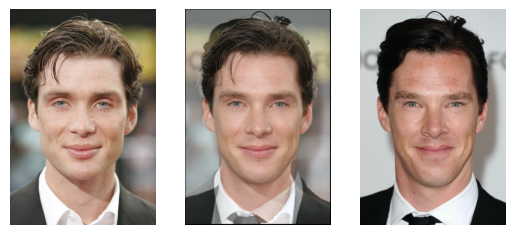

In [26]:
alpha = 0.5
midwayimg = cillianwarped*alpha + benedictwarped*(1-alpha)
plt.subplot(131)
plt.imshow(plt.imread('cillianresized.jpg'))
plt.axis('off')
plt.subplot(133)
plt.imshow(plt.imread('benedictresized.jpg'))
plt.axis('off')
plt.subplot(132)
plt.imshow(midwayimg)
plt.axis('off')
plt.savefig('midwayface.jpg')

<h3>Part 3: The Morph Sequence</h3>

In [39]:
def morph(im1, im2, im1_pts, im2_pts, midpoints, warp_frac, dissolve_frac):
    morphed_frames = []
    warp_frac += 0.5 #this is bc of the way my warp function is configured. I know logically it shouldn't be the case, but this will get us the perfect morph sequence we want
    for f in range(45):
        print(f)
        #get where curr warped pts are and apply the warp
        curr_pts = im1_pts*warp_frac + im2_pts*(1-warp_frac)
        im1warped = warp('cillianresized.jpg', midpoints, im1_pts, curr_pts)
        im2warped = warp('benedictresized.jpg', midpoints, im2_pts, curr_pts)
        #cross-dissolve
        morphed_img = im1warped*(1-dissolve_frac) + im2warped*dissolve_frac
        #add it as one of the 45 frames
        morphed_frames.append(morphed_img)
        warp_frac += 1/(44*2) #bc my warp_frac starts at 0.5
        dissolve_frac += 1/44
    return morphed_frames

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


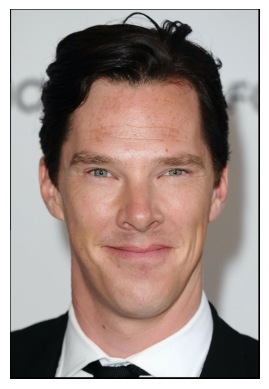

In [40]:
cillian = plt.imread('cillianresized.jpg')
benedict = plt.imread('benedictresized.jpg')
morphed_img = morph(cillian, benedict, cillianpts, benedictpts, cb_midpoints, 0,0)

In [59]:
writer = imageio.get_writer('morphseq.gif', duration=1/30)

# Write each frame to the GIF
for frame in morphed_img:
    writer.append_data(frame)

# Close the writer to finalize the GIF
writer.close()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

<h3>Part 4: The "Mean face" of a population</h3>

In [212]:
im = plt.imread('danes/01-1m.bmp')
print(im.shape)
danes_height = im.shape[0]
danes_width = im.shape[1]
color_channels = 3
num_danes = 36

(480, 640, 3)


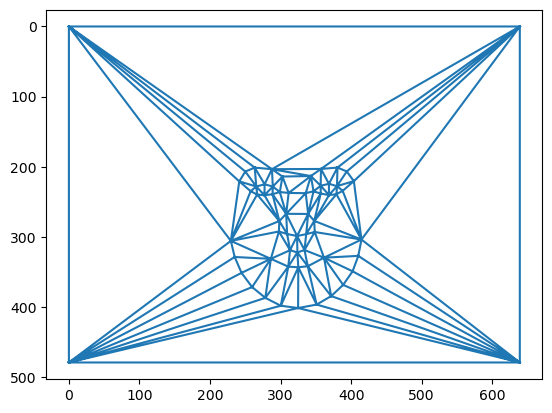

In [213]:
#Compute avg face shape

# #go through all images
# faces = np.zeros((danes_height, danes_width, color_channels, num_danes))
# count = 0
# for file in os.listdir('danes'):
#     if file.endswith('.bmp'): #actual image
#         currface = plt.imread(os.path.join('danes', file))
#         faces[:,:,:,count] = plt.imread(os.path.join('danes', file))/255
#         count+=1
#go through to get points
corners = np.array([(0,0),(0,danes_height-1),(danes_width-1,0),(danes_width-1,danes_height-1)])
aggpoints = np.zeros((62,2))
fct = 0
all_danes_pts = []
for file in sorted(os.listdir('danes')):
    if file.endswith('.asf'): #to get points
        fname = os.path.splitext(file)[0]
        # print(fname)
        fct += 1
        linecount = 1
        currface = open(os.path.join('danes', file))
        pts = []#np.zeros((58,2))
        line = currface.readline() #get the first line
        while line != '': #basically get to the end of the file where there's data
            if linecount >= 17 and linecount <= 74: #based on the asf files, these have data we need
                l = line.split()
                pts = np.append(pts, [float(l[2])*danes_width, float(l[3])*danes_height]) #the 3rd and 4th elements are <x rel.> and <y rel.>
            linecount += 1
            line = currface.readline() #get the next line
        pts = pts.reshape((58,2))
        if (pts.shape == (58,2)):
            pts = np.vstack((pts, corners))
            all_danes_pts.append(pts) #store its points
            
            aggpoints += pts
avgface = aggpoints/fct
#print(avgface)
danes_triangulation = Delaunay(avgface)

plt.gca().invert_yaxis()
plt.triplot(avgface[:, 0], avgface[:, 1], danes_triangulation.simplices)
plt.savefig('danes_triangle_mesh.jpg')

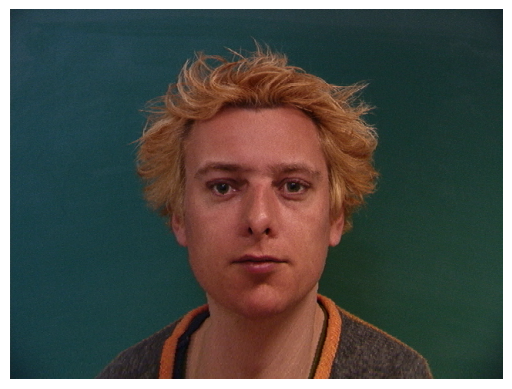

In [214]:
#Morph each face to the avg
faces = np.zeros((danes_height, danes_width, color_channels, num_danes))
count = 0
im2 = plt.imread('black.jpg')
if os.path.exists('danes_warped') == False:
    os.makedirs('danes_warped')
for file in sorted(os.listdir('danes')):
    if file.endswith('.bmp'): #actual image
        currface = plt.imread(os.path.join('danes', file))
        faces[:,:,:,count] = plt.imread(os.path.join('danes', file))/255
        warped_im = warp('danes/'+file, avgface, all_danes_pts[count])
        #warped_im = morph(faces[:,:,:,count], im2, all_danes_pts[count], avgface, danes_triangulation, warp_frac=1, dissolve_frac=0)
        plt.imshow(warped_im)
        imname = 'danes_warped/dane' +str(count)+ 'warped.jpg'
        plt.savefig(imname)
        count+=1

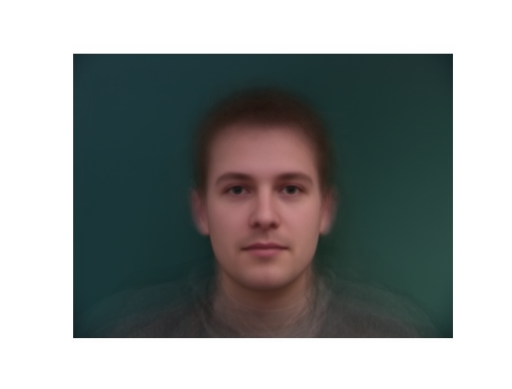

In [222]:
#Compute avg face of population (blend all the morphed faces)
average = np.zeros((480,640,3))
for file in sorted(os.listdir('danes_warped')):
    im = plt.imread('danes_warped/'+file)/255
    average += im
average /= num_danes
plt.axis('off')
plt.imshow(average)
plt.savefig('mean_danes_face.jpg')

In [43]:
def get_midpoints(json_fname):
    #correspondences my face and mean danes
    with open(json_fname, 'r') as correspondences:
        points = json.load(correspondences)

    im1pts = np.array(points['im1Points'])
    im2pts = np.array(points['im2Points'])#cath

    #  calculate midpoints
    midpoints = []
    for p_im1, p_im2 in zip(im1pts, im2pts):
        mean_x = (p_im1[0] + p_im2[0]) / 2
        mean_y = (p_im1[1] + p_im2[1]) / 2
        midpoints.append([mean_x, mean_y])

    midpoints = np.array(midpoints)
    return im1pts, im2pts, midpoints

In [316]:
meandanepts, cathpts, midpoints_cathdane = get_midpoints('meandane_cath.json')

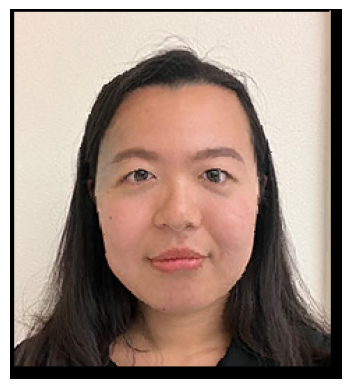

In [314]:
#my face warped into the mean dane face
warped_cath_as_dane = warp('cath_resized.jpg', meandanepts, cathpts)
plt.savefig('cath_as_dane.jpg')


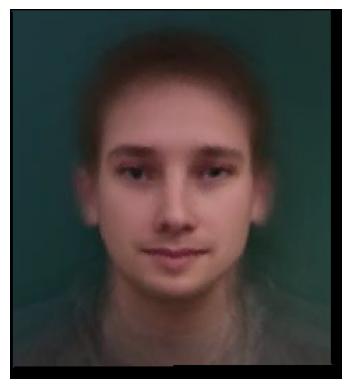

In [305]:
#mean dane face warped into my face
warped_dane_as_cath = warp('mean_danes_resized.jpg', cathpts, meandanepts)
plt.savefig('dane_as_cath.jpg')

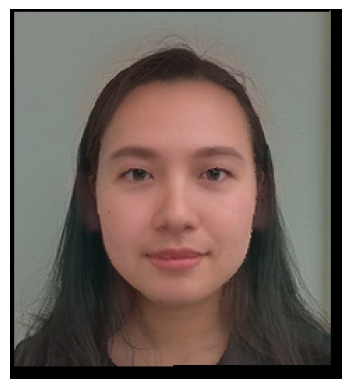

In [317]:
#morph me into danishman (both shape and appearance)
cathwarped = warp('cath_resized.jpg', midpoints_cathdane, cathpts)
danishmanwarped = warp('mean_danes_resized.jpg', midpoints_cathdane, meandanepts)
danishmancath_fullmorph = cathwarped*0.5 + danishmanwarped*(1-0.5)
plt.imshow(danishmancath_fullmorph)
plt.savefig('danishmancath_fullmorph.jpg')

<h3>Part 5: Caricatures, Extrapolating from the mean</h3>

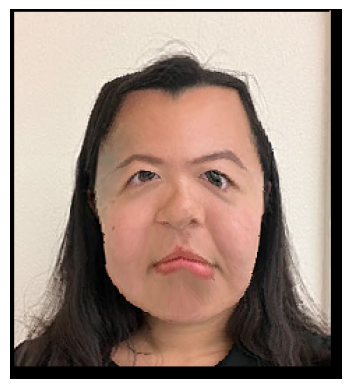

In [249]:
cath_minus_danishmean = cathpts - meandanepts
cath_ch = cathpts + cath_minus_danishmean

cath_caricature = warp('cath_resized.jpg', meandanepts, cath_ch)
plt.savefig('cath_caricature.jpg')

<h3>Mandatory Bells and Whistles</h3>

In [318]:
frenchmanpts, cathptsf, midpoints_cathfrench = get_midpoints('frechman_cath.json')

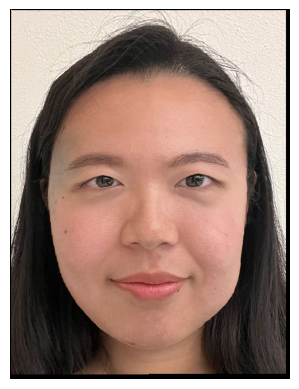

In [319]:
#my face warped into the shape of the mean frenchman face
frenchmancath_shapemorph = warp('cath_resized2.jpg', frenchmanpts, cathptsf)
plt.savefig('frenchmancath_shapemorph.jpg')

In [42]:
def morph_im(impath1, impath2, im1_pts, im2_pts, midpoints, warp_frac, dissolve_frac):
    #get where curr warped pts are and apply the warp
    curr_pts = im1_pts*warp_frac + im2_pts*(1-warp_frac)
    im1warped = warp(impath1, midpoints, im1_pts, curr_pts)
    im2warped = warp(impath2, midpoints, im2_pts, curr_pts)
    #cross-dissolve
    morphed_img = im1warped*(1-dissolve_frac) + im2warped*dissolve_frac
    return morphed_img

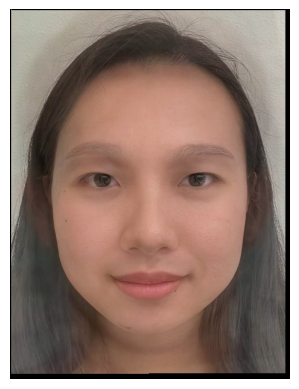

In [320]:
#my face warped into the appearance of the mean frenchman face
frenchmancath_appearancemorph = morph_im('cath_resized2.jpg', 'frenchman_resized.jpg', cathptsf, frenchmanpts, midpoints_cathfrench, 0.5,0.5)
plt.imshow(frenchmancath_appearancemorph)
plt.savefig('frenchmancath_appearancemorph.jpg')

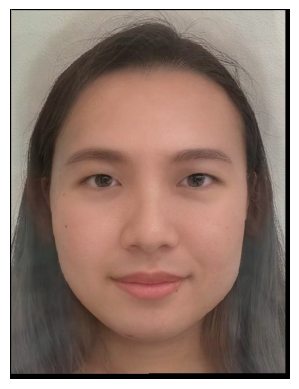

In [321]:
#morph both shape and appearance
cathwarped = warp('cath_resized2.jpg', midpoints_cathfrench, cathptsf)
frenchmanwarped = warp('frenchman_resized.jpg', midpoints_cathfrench, frenchmanpts)
frenchmancath_fullmorph = cathwarped*0.5 + frenchmanwarped*(1-0.5)
plt.imshow(frenchmancath_fullmorph)
plt.savefig('frenchmancath_fullmorph.jpg')

<h3>Bells and Whistles Cont: Me as Women of the World</h3>

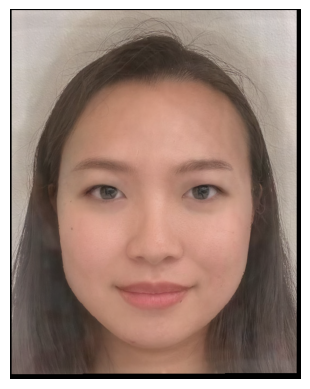

In [50]:
#English Lady Catherine
englishpts, cathptsenglish, midpoints_cathenglish = get_midpoints('cath_english.json')

#morph both shape and appearance
cathenglish = warp('cath_world.jpg', midpoints_cathenglish, cathptsenglish)
englishwarped = warp('english.jpg', midpoints_cathenglish, englishpts)
englishcath_fullmorph = cathenglish*0.5 + englishwarped*(1-0.5)
plt.imshow(englishcath_fullmorph)
plt.savefig('englishcath_fullmorph.jpg')

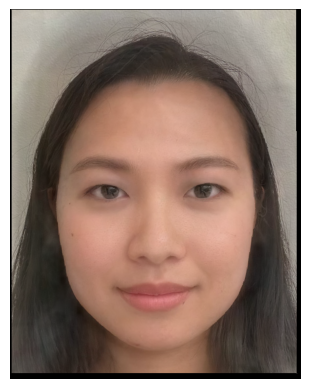

In [51]:
#Mexican Lady Catherine
cathptsmexican, mexicanpts, midpoints_cathmexican = get_midpoints('cath_mexican.json')

#morph both shape and appearance
cathmexican = warp('cath_world.jpg', midpoints_cathmexican, cathptsmexican)
mexicanwarped = warp('mexican.jpg', midpoints_cathmexican, mexicanpts)
mexicancath_fullmorph = cathmexican*0.5 + mexicanwarped*(1-0.5)
plt.imshow(mexicancath_fullmorph)
plt.savefig('mexicancath_fullmorph.jpg')

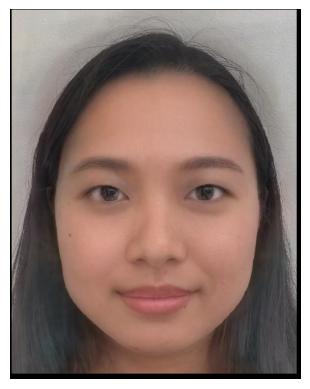

In [52]:
#Indian Lady Catherine
cathptsindian, indianpts, midpoints_cathindian = get_midpoints('cath_indian.json')

#morph both shape and appearance
cathindian = warp('cath_world.jpg', midpoints_cathindian, cathptsindian)
indianwarped = warp('indian.jpg', midpoints_cathindian, indianpts)
indiancath_fullmorph = cathindian*0.5 + indianwarped*(1-0.5)
plt.imshow(indiancath_fullmorph)
plt.savefig('indiancath_fullmorph.jpg')

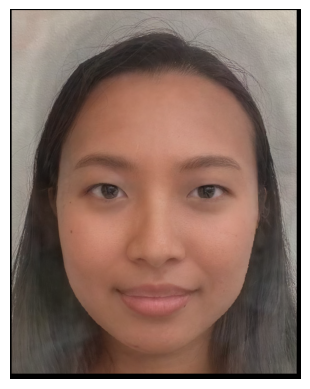

In [53]:
#Ethiopian Lady Catherine
cathptsethiopian, ethiopianpts, midpoints_cathethiopian = get_midpoints('cath_ethiopian.json')

#morph both shape and appearance
cathethiopian = warp('cath_world.jpg', midpoints_cathethiopian, cathptsethiopian)
ethiopianwarped = warp('ethiopian.jpg', midpoints_cathethiopian, ethiopianpts)
ethiopiancath_fullmorph = cathethiopian*0.5 + ethiopianwarped*(1-0.5)
plt.imshow(ethiopiancath_fullmorph)
plt.savefig('ethiopiancath_fullmorph.jpg')

<h3>Now I wanna do stuff to get morph sequence between the images of me as different ethnicities</h3>
This will include (sadly) having to recalculate correspondences between each image.

The order of the morph sequence will be:

    - normal -> english -> mexican -> indian -> ethiopian
    
    - there will be 5 sets of correspondence pairs so it keeps looping seamlessly

In [54]:
def quick_morph(impath1, impath2, im1_pts, im2_pts, midpoints, warp_frac, dissolve_frac):
    morphed_frames = []
    warp_frac += 0.5 #same as above, just this is how my warp function works to get the perfect sequence
    for f in range(5):
        print(f)
        #get where curr warped pts are and apply the warp
        curr_pts = im1_pts*warp_frac + im2_pts*(1-warp_frac)
        im1warped = warp(impath1, midpoints, im1_pts, curr_pts)
        im2warped = warp(impath2, midpoints, im2_pts, curr_pts)
        #cross-dissolve
        morphed_img = im1warped*(1-dissolve_frac) + im2warped*dissolve_frac
        #add it as one of the 4 frames
        morphed_frames.append(morphed_img)
        warp_frac += 1/(4*2) #also bc of the 0.5 start for warp_frac
        dissolve_frac += 1/4
    return morphed_frames

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


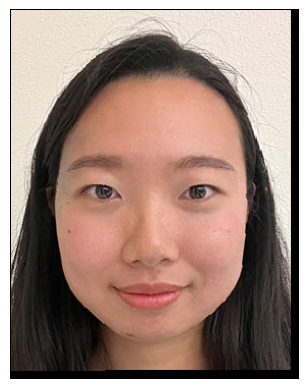

In [68]:
cath_morphed_frames = []

normalcathpts, englishcathpts, midpoints_normeng = get_midpoints('cathwomenworld/normalenglish.json')
cath_morphed_frames += quick_morph('cathwomenworld/normalcath.jpg', 'cathwomenworld/englishcath.jpg',
                                normalcathpts, englishcathpts, midpoints_normeng, 0,0)
englishcathpts, mexicancathpts, midpoints_engmex = get_midpoints('cathwomenworld/englishmexican.json')
cath_morphed_frames += quick_morph('cathwomenworld/englishcath.jpg', 'cathwomenworld/mexicancath.jpg',
                                    englishcathpts, mexicancathpts, midpoints_engmex, 0,0)
mexicancathpts, indiancathpts, midpoints_mexind = get_midpoints('cathwomenworld/mexicanindian.json')
cath_morphed_frames += quick_morph('cathwomenworld/mexicancath.jpg', 'cathwomenworld/indiancath.jpg',
                                    mexicancathpts, indiancathpts, midpoints_mexind, 0,0)
indiancathpts, ethiopiancathpts, midpoints_indethi = get_midpoints('cathwomenworld/indianethiopian.json')
cath_morphed_frames += quick_morph('cathwomenworld/indiancath.jpg', 'cathwomenworld/ethiopiancath.jpg',
                                    indiancathpts, ethiopiancathpts, midpoints_indethi, 0,0)
ethiopiancathpts, normalcathpts, midpoints_ethinorm = get_midpoints('cathwomenworld/ethiopiannormal.json')
cath_morphed_frames += quick_morph('cathwomenworld/ethiopiancath.jpg', 'cathwomenworld/normalcath.jpg',
                                    ethiopiancathpts, normalcathpts, midpoints_ethinorm, 0,0)

In [69]:
writer = imageio.get_writer('cathwomenworld/cath_ethnicities.gif', duration=1/4)

# Write each frame to the GIF
for frame in cath_morphed_frames:
    writer.append_data(frame)

# Close the writer to finalize the GIF
writer.close()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0